In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tailor

### Create initial DataFrame

In [2]:
raw_df = tailor.load_data()
raw_df.article_id = raw_df.article_id.astype(int)
df_revenue = raw_df[['article_id', 'time_on_sale', 'revenue']]

To give an example, the dataframe looks like this ...

In [3]:
df_revenue.head()

,article_id,time_on_sale,revenue
0,900001,0,217.483333
1,900001,1,333.230000
2,900001,2,315.233333
3,900001,3,399.172500
4,900001,4,337.716667


### Create a Benchmark Series

Now reshape the dataframes into a format which makes it easier to calculate the mean of each time_on_sale value.  The following steps must be done for each  performance measure.  For now, we will just do it for the dataframe with the column 'revenue' (df_revenue)



In [4]:
df_pivoted = df_revenue.pivot_table(
    values='revenue', index='article_id', columns='time_on_sale')
# cast pivot table into DataFrame
df_reshaped = pd.DataFrame(df_pivoted.to_records())
df_reshaped.head()

,article_id,0,1,2,3,4,5,6,7,8,...,16,17,18,19,20,21,22,23,24,25
0,900001,217.483333,333.230000,315.233333,399.172500,337.716667,318.932000,526.558333,324.423333,349.486667,...,329.700000,339.165714,448.111667,401.236667,327.585000,258.413333,245.796667,161.514286,195.900,88.016667
1,900002,153.301667,366.036667,399.931667,489.950000,566.735714,471.391667,511.267143,451.990000,440.414286,...,301.678333,246.612000,211.118571,229.086667,228.201667,215.748333,185.760000,142.350000,138.875,293.455000
2,900003,164.401667,256.011667,236.522857,238.227143,336.184286,283.264286,388.250000,412.515714,341.580000,...,606.630000,506.663333,424.105000,422.403333,340.841667,287.366667,257.373333,159.990000,88.152,63.743333
3,900004,87.390000,171.200000,168.610000,209.880000,233.978571,194.122000,309.560000,271.420000,218.172857,...,207.621667,196.691667,238.170000,195.748571,193.698333,75.344000,74.805000,24.812500,34.415,33.037500
4,900005,105.545000,104.073333,161.033333,208.620000,133.070000,186.827500,250.278333,112.463333,133.913333,...,154.371667,189.043333,325.191667,204.913333,161.285000,96.706667,46.131667,52.585000,47.880,51.370000


Next, calculate the mean of each column. Therefore, you have the mean for each time_on_sale value. This series can be used as a benchmark series. 

In [5]:
revenue_benchmark = df_reshaped.mean(axis=0)
revenue_benchmark.head()

article_id    904354.500000
0                158.368778
1                253.207828
2                287.590034
3                309.596904
dtype: float64

Drop mean of article ids. It makes no sense and we dont need it 

In [6]:
revenue_benchmark = revenue_benchmark.drop(revenue_benchmark.index[0])
revenue_benchmark.head()

0    158.368778
1    253.207828
2    287.590034
3    309.596904
4    330.828999
dtype: float64

Cast series into a DataFrame

In [7]:
df_revenue_benchmark = pd.DataFrame()
df_revenue_benchmark['time_on_sale'] = revenue_benchmark.keys().astype(int)
df_revenue_benchmark['mean_revenue'] = revenue_benchmark.values
df_revenue_benchmark.head()

,time_on_sale,mean_revenue
0,0,158.368778
1,1,253.207828
2,2,287.590034
3,3,309.596904
4,4,330.828999


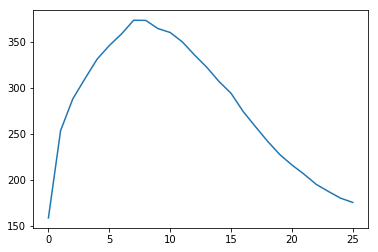

In [8]:
plt.plot(df_revenue_benchmark.time_on_sale, df_revenue_benchmark.mean_revenue);

### Calculate distance to Benchmark Series

Merging both DataFrames yields in ...

In [9]:
result = pd.merge(df_revenue, df_revenue_benchmark, how='left', on='time_on_sale',
                  left_index=False, right_index=True, sort=True, validate='m:1')
result = result.reset_index()
result = result.drop('index', axis=1)
result = result.rename(index=str, columns={'mean_revenue_y': 'mean_revenue'})
result.head()

,article_id,time_on_sale,revenue,mean_revenue
0,900001,0,217.483333,158.368778
1,900002,0,153.301667,158.368778
2,900003,0,164.401667,158.368778
3,900004,0,87.390000,158.368778
4,900005,0,105.545000,158.368778


Calculate the distance between revenue and mean_revenue

In [10]:
result['distance'] = ((result['revenue'] - result['mean_revenue'])**2)**0.5
result.head()

,article_id,time_on_sale,revenue,mean_revenue,distance
0,900001,0,217.483333,158.368778,59.114555
1,900002,0,153.301667,158.368778,5.067111
2,900003,0,164.401667,158.368778,6.032889
3,900004,0,87.390000,158.368778,70.978778
4,900005,0,105.545000,158.368778,52.823778


Sum up all distances to get just one value for similiarity measurement

In [11]:
result = result.groupby('article_id').sum()
result = result.reset_index()
result = result.drop(['revenue', 'mean_revenue'], axis=1)
result.head()

,article_id,time_on_sale,distance
0,900001,325,2216.387136
1,900002,325,2041.660817
2,900003,325,4189.801419
3,900004,325,3101.677468
4,900005,325,3334.574988


In [12]:
result = result.sort_values('distance', ascending=True)
result.head()

,article_id,time_on_sale,distance
776,900777,15,477.493567
4345,904346,64,760.289460
8405,908406,10,864.132233
274,900275,30,919.121152
5278,905279,69,950.105274


### First evaluation of the similarity measurement

Plot the two article with the lowest distance 

In [13]:
lowest_distance = result.iloc[0]
second_lowest_distance = result.iloc[1]
df_revenue_lowest = df_revenue[df_revenue['article_id']
                               == lowest_distance.article_id]
df_revenue_second_lowest = df_revenue[df_revenue['article_id']
                                      == second_lowest_distance.article_id]

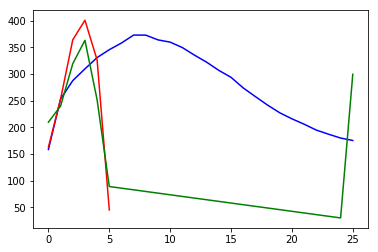

In [14]:
plt.plot(df_revenue_benchmark.time_on_sale,
         df_revenue_benchmark.mean_revenue, 'b')
plt.plot(df_revenue_lowest.time_on_sale, df_revenue_lowest.revenue, 'r')
plt.plot(df_revenue_second_lowest.time_on_sale,
         df_revenue_second_lowest.revenue, 'g');

Let us plot some articles with similiar distances. To find similiar values, I just had a look at the sorted result dataframe

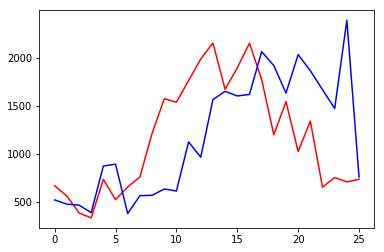

In [15]:
article_one = raw_df[raw_df['article_id'] == 902792]
article_two = raw_df[raw_df['article_id'] == 901825]

plt.plot(article_one['time_on_sale'], article_one['revenue'], 'r')
plt.plot(article_two['time_on_sale'], article_two['revenue'], 'b');

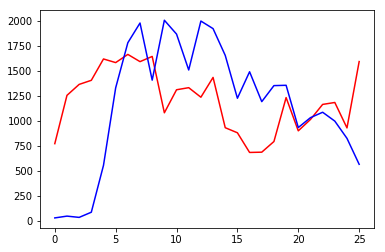

In [16]:
article_three = raw_df[raw_df['article_id'] == 900546]
article_four = raw_df[raw_df['article_id'] == 906171]

plt.plot(article_three['time_on_sale'], article_three['revenue'], 'r')
plt.plot(article_four['time_on_sale'], article_four['revenue'], 'b');